# Contoh Model Dense PyTorch untuk Klasifikasi MNIST

Import library yang akan digunakan seperti berikut

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

Untuk contoh ini, kita akan menggunakan dataset terkenal MNIST

MNIST merupakan dataset klasik yang merepresentasikan angka dalam tulisan tangan

In [2]:
# Transformasi data - mengubah gambar menjadi tensor dan normalisasi
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Mean dan std dev dari MNIST
])

# Download dan load dataset training
train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Download dan load dataset test
test_dataset = datasets.MNIST('data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.78MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.4MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 110] Connection timed out>



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.03MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Untuk mengenal dataset lebih lanjut, kita dapat memvisualisasikannya seperti berikut:

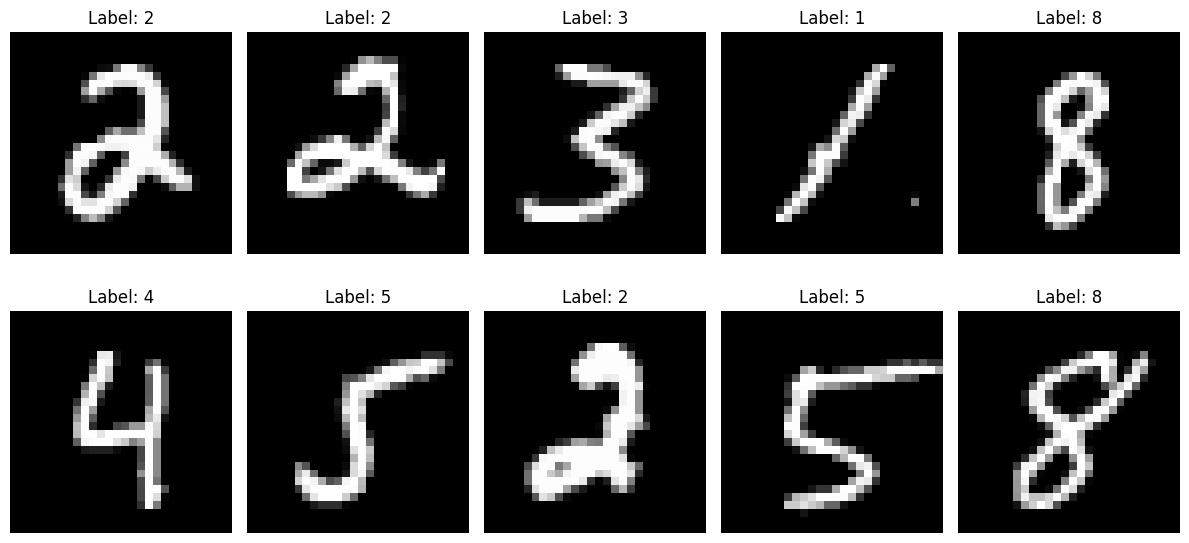

In [3]:
def plot_samples(dataloader):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    axes = axes.ravel()
    
    for idx in range(10):
        axes[idx].imshow(images[idx].squeeze(), cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f'Label: {labels[idx]}')
    
    plt.tight_layout()
    plt.show()

plot_samples(train_loader)

Lalu kita rancang arsitektur modelnya dengan 3 dense layer

In [4]:
class SimpleDenseModel(nn.Module):
    def __init__(self):
        super(SimpleDenseModel, self).__init__()
        # Input: 28x28 = 784 pixels
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(784, 128)
        self.dense2 = nn.Linear(128, 64)
        self.dense3 = nn.Linear(64, 10)  # 10 kelas (digit 0-9)
    
    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        x = self.dense3(x)
        return F.log_softmax(x, dim=1)

# Inisialisasi model
model = SimpleDenseModel()
# Pindahkan ke GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Definisikan optimizer dan loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

Selanjutnya kita buat juga fungsi untuk training dan testing modelnya

In [5]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Pindahkan data ke device (CPU/GPU)
        data, target = data.to(device), target.to(device)
        
        # Reset gradient
        optimizer.zero_grad()
        
        # Forward pass
        output = model(data)
        
        # Hitung loss
        loss = criterion(output, target)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Print progress
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():  # Tidak perlu menghitung gradient untuk testing
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({accuracy:.2f}%)\n')
    
    return accuracy

Panggil kedua fungsi tersebut

In [9]:
# List untuk menyimpan metrics
accuracies = []

# Training loop
n_epochs = 4
for epoch in range(1, n_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    accuracy = test(model, device, test_loader)
    accuracies.append(accuracy)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.165956
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.045780
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.024324
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.009909
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.013833
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.008694
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.028331
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.029301
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.090703
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.093558

Test set: Average loss: 0.0834, Accuracy: 9763/10000 (97.63%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.011950
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.005358
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.046300
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.050612
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.007565
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.075273
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.034835
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.017609
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.02388

Kita dapat melihat bagaimana perkembangan machine learningnya dengan menggunakan visualisasi per epochnya

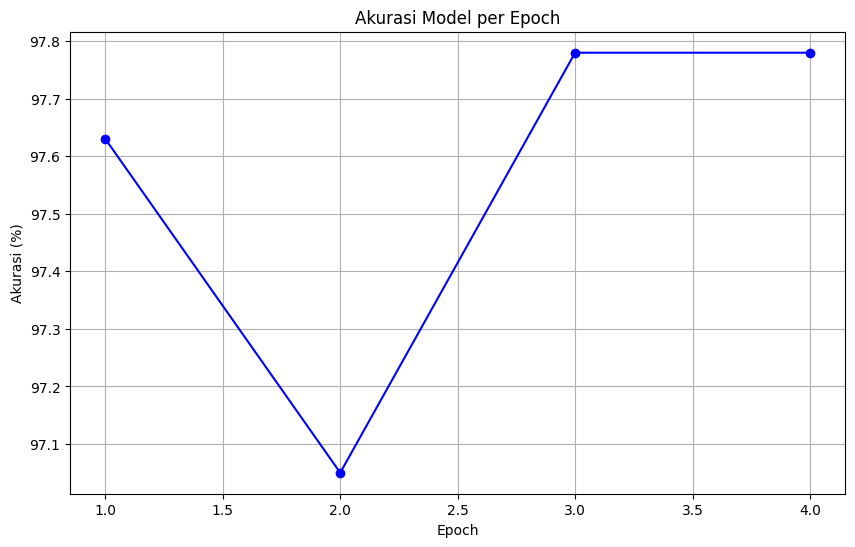

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), accuracies, 'bo-')
plt.title('Akurasi Model per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Akurasi (%)')
plt.grid(True)
plt.show()

Dan akhirnya simpan model yang sudah kita train

In [11]:
torch.save(model.state_dict(), 'mnist_model.pth')
print("Model berhasil disimpan sebagai 'mnist_model.pth'")

Model berhasil disimpan sebagai 'mnist_model.pth'
